In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, eig, pinv
from scipy import linalg
from scipy import pi, multiply, power, tanh, exp, cosh
% matplotlib inline
from scipy import random

In [2]:
from warnings import warn

In [3]:
import scipy

In [4]:
import dask.array as da

We modify the code in the following [blog]( http://www.pyrunner.com/weblog/2016/07/25/dmd-python/.) to create dask DMD:

Below we define dask functions for DMD decomposition:

In [5]:
# Dask DMD function

def dmd_dask(D,r):
    
    # offsets
    X_da = D[:,:-1]
    Y_da = D[:,1:]

    # SVD
    u,s,v = da.linalg.svd(X_da)

    # rank truncaction
    u = u[:,:r]
    Sig = da.diag(s)[:r,:r]
    v = v.conj().T[:,:r]
    
    # build A tilde
    Atil = da.dot(da.dot(da.dot(u.conj().T, Y_da), v), inv(Sig))
    
    # dask does not have an eig function
    mu,W = eig(Atil)
    
    # build DMD modes
    Phi = da.dot(da.dot(da.dot(Y_da, v), inv(Sig)), W)
    
    return(mu,Phi,s)
    
def dmd_evolve_dask(X0,mu,Phi,t):
    # compute time evolution
    b = da.dot(pinv(Phi), X0)
    r = Phi.shape[1]
    Psi = np.zeros([r, len(t)], dtype='complex')
    for i,_t in enumerate(t):
        Psi[:,i] = multiply(power(mu, _t), b)
    
    return(Psi)

And this is the equivalent pure numpy function:

In [6]:
# numpy DMD function

def dmd(D,r):
    
    # offsets
    X = D[:,:-1]
    Y = D[:,1:]

    # SVD
    u,s,v = linalg.svd(X,False)

    # rank truncaction
    u = u[:,:r]
    Sig = np.diag(s)[:r,:r]
    v = v.conj().T[:,:r]
    
    # build A tilde
    Atil = np.dot(np.dot(np.dot(u.conj().T, Y), v), inv(Sig))
    mu,W = eig(Atil)
    
    # build DMD modes
    Phi = np.dot(np.dot(np.dot(Y, v), inv(Sig)), W)
    
    return(mu, Phi, s)

def dmd_evolve(X0,mu,Phi,t):   
    
    # compute time evolution
    b = np.dot(pinv(Phi), X0)
    r = Phi.shape[1]
    Psi = np.zeros([r, len(t)], dtype='complex')
    for i,_t in enumerate(t):
        Psi[:,i] = multiply(power(mu, _t), b)
    
    return(Psi)

We also add a function to check if the decomposition is good.

In [7]:
def check_dmd(D, mu, Phi, show_warning=True):
    X = D[:,0:-1]
    Y = D[:,1:]
    b = np.allclose(Y, np.dot(np.dot(np.dot(Phi, np.diag(mu)), pinv(Phi)), X))
    if not b and show_warning:
        warn('dmd result does not satisfy Y=AX')

In [8]:
def check_dmd_dask(D, mu, Phi, show_warning=True):
    X = D[:,0:-1]
    Y = D[:,1:]
    b = np.allclose(Y, da.dot(da.dot(da.dot(Phi, da.diag(mu)), pinv(Phi)), X))
    if not b and show_warning:
        warn('dmd result does not satisfy Y=AX')

#### Example 1: Spatiotemporal Pattern

Generate an array from 3 components. The example is from the [blog](http://www.pyrunner.com/weblog/2016/07/25/dmd-python/). We increase the dimensions to test performance on a bigger dataset.

In [9]:
# define time and space domains
x = np.linspace(-10, 10, 100)
t = np.linspace(0, 6*pi, 80)
dt = t[2] - t[1]
Xm,Tm = np.meshgrid(x, t)

# create three spatiotemporal patterns
f1 = multiply(20-0.2*power(Xm, 2), exp((2.3j)*Tm))
f2 = multiply(Xm, exp(0.6j*Tm))
f3 = multiply(5*multiply(1/cosh(Xm/2), tanh(Xm/2)), 2*exp((0.1+2.8j)*Tm))

# combine signals and make data matrix
D = (f1 + f2 + f3).T

In [10]:
# convert array to dask array
D_da = da.from_array(D, (100,80))

In [14]:
%%time 
mu, Phi, s = dmd_dask(D_da,3)
Psi = dmd_evolve_dask(D_da[:,0],mu,Phi,t)

CPU times: user 236 ms, sys: 432 ms, total: 668 ms
Wall time: 377 ms


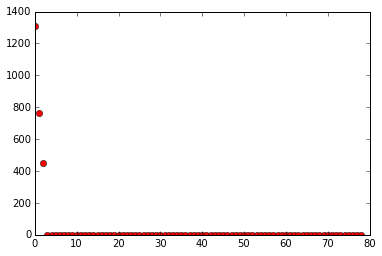

In [15]:
plt.plot(s,'ro')

In [16]:
print(check_dmd(D_da,mu,Phi))

None


In [17]:
print(check_dmd_dask(D_da,mu,Phi))

None


/home/val/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


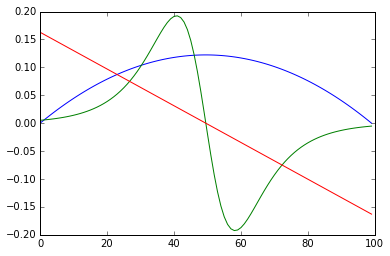

In [18]:
plt.plot(Phi)

#### Example 2: Moving Disk

We generate a simple video of a moving circle.

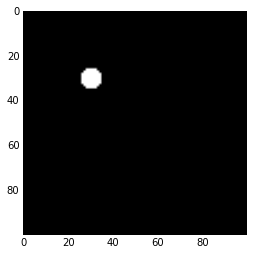

In [19]:
k = 1 # k allows to scale the dimensions of the images
c = (30*k,30*k)
m,n = 100*k,100*k
r = 5*k

def create_circle(m,n,c,r):
    """
        Function creating an mxn image of a circle centered at c with radius.
    """
    circle_image = np.zeros((m,n))
    I,J = np.meshgrid(range(m),range(n))
    circle_image[(I-c[0])**2 + (J-c[1])**2<(r**2)] = 1
    return(circle_image)

circle_image = create_circle(m,n,c,r)
plt.imshow(circle_image,cmap = 'gray')

In [20]:
# create an array of ones:
m, n, T = (100,100,100)
frames = np.ones((m,n,T))

In [21]:
# create a video of a moving circle
for t in range(T):
    c = c + np.random.normal(0.5,1,2)
    circle_image = create_circle(m,n,c,r)
    frames[:,:,t] = circle_image

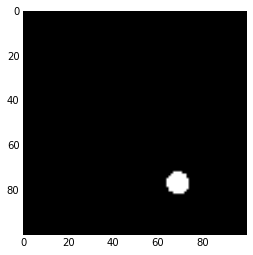

In [22]:
plt.imshow(frames[:,:,90],cmap = 'gray')

In [23]:
# convert array to dask array
D = np.reshape(frames,(m*n,T))
D_da = da.from_array(D,chunks = (100,T))

In [35]:
%%time
mu, Phi, s = dmd(D,1)
Psi = dmd_evolve(D[:,0],mu,Phi,range(T))

CPU times: user 344 ms, sys: 604 ms, total: 948 ms
Wall time: 429 ms


In [36]:
%%time 
mu, Phi, s = dmd_dask(D_da,1)
Psi = dmd_evolve_dask(D_da[:,0],mu,Phi,range(T))

CPU times: user 7.8 s, sys: 4.67 s, total: 12.5 s
Wall time: 8.75 s


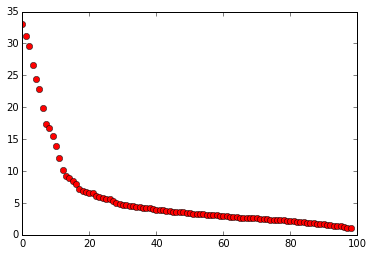

In [37]:
plt.plot(s,'ro')

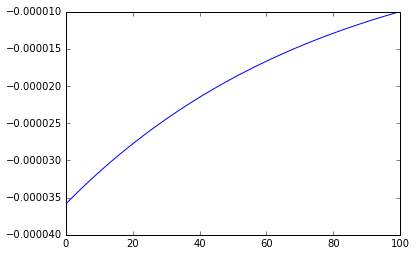

In [38]:
plt.plot(np.real(Psi.T))

In [39]:
check_dmd(D,mu,Phi)

/home/val/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: dmd result does not satisfy Y=AX


In [40]:
check_dmd_dask(D_da,mu,Phi)

/home/val/MEGA/eScienceWork/projects/daskDMD/daskDMD.py:140: UserWarning: dmd result does not satisfy Y=AX
  warn('dmd result does not satisfy Y=AX')


In [41]:
# reconstruct background and motion

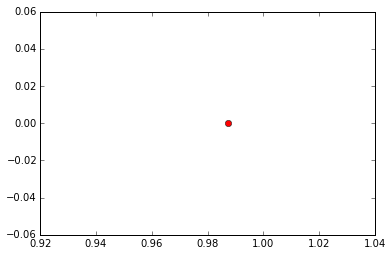

In [42]:
plt.plot(np.real(mu),np.imag(mu),'ro')

In [46]:
m = 0

In [47]:
modeProj = np.dot(np.reshape(Phi[:,m],(10000,1)),np.reshape(Psi[m,:],(1,100)))

In [49]:
frames_new = np.reshape(modeProj,(100,100,100))

/home/val/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


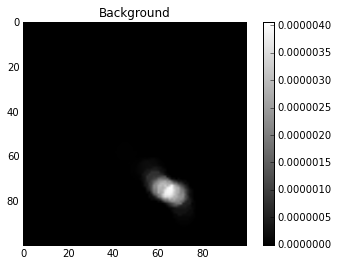

In [83]:
plt.imshow(np.real(frames_new[:,:,10]),cmap = 'gray')
plt.colorbar()
plt.title('Background')

We see that there is some shadow left from the foreground, however, when we look at the colorbar we realize it is on a very small scale. We normalized the image display between 0 and 1.

/home/val/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


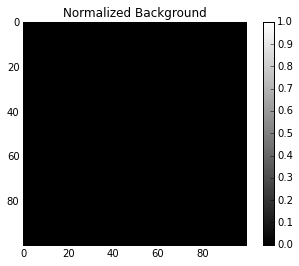

In [73]:
plt.imshow(np.real(frames_new[:,:,10]),vmin=0, vmax=1,cmap = 'gray')
plt.colorbar()
plt.title('Normalized Background')

/home/val/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


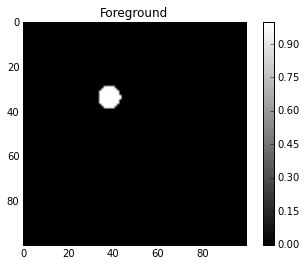

In [74]:
plt.imshow(np.real(frames[:,:,10] - frames_new[:,:,10]),cmap = 'gray')
plt.colorbar()
plt.title('Foreground')

The foreground looks equivalent to the original image:

/home/val/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


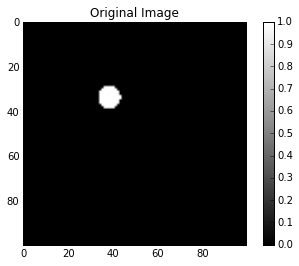

In [78]:
plt.imshow(frames[:,:,10],cmap = 'gray')
plt.colorbar()
plt.title('Original Image')

####  Example 3: Simulated Sonar Data

In [84]:
# read the data (later I should use dask imread to read it an avoid h5py)

In [85]:
import h5py

In [86]:
f = h5py.File("test_data/simu_data.h5", "r")

In [87]:
data = f['data']

In [88]:
# set the dimensions

p = 240 # number of pins
d = data.shape[0] # depth
T = int(data.shape[1]/p)
print(p,d,T)

240 1046 80


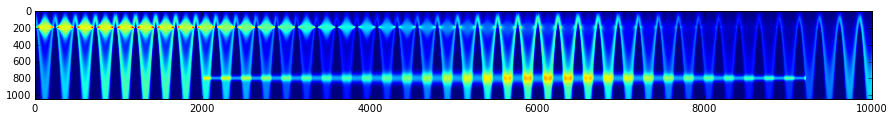

In [89]:
plt.figure(figsize = (15,10))
plt.imshow(data[:,:10000])

In [90]:
data.shape

(1046, 19200)

In [91]:
# reshape to (depth x pins) x T
data_np = np.array(data).reshape((p*d,T),order = 'F')

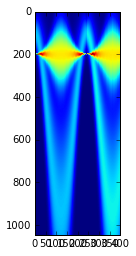

In [92]:
# reshape back
plt.imshow(data_np.reshape((d,T*p),order = 'F')[:,:400])

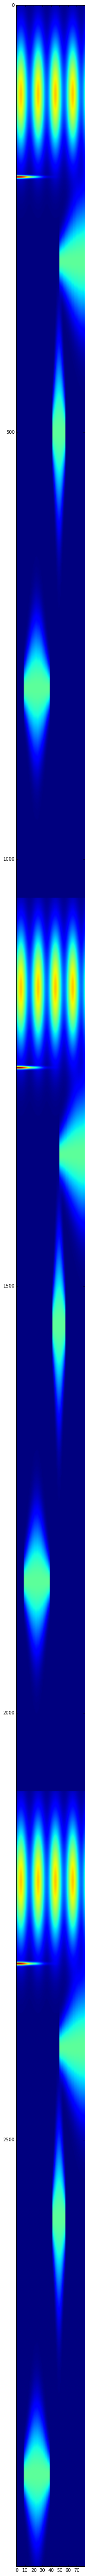

In [93]:
# show the transformed data
plt.figure(figsize = (5,100))
plt.imshow(data_np[:3000,:])

Looks weird, but it is transformed!

In [94]:
data_da = da.from_array(data_np,chunks = (100,80))

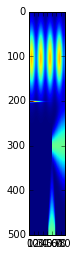

In [95]:
plt.imshow(data_np[:500,:])

In [96]:
T = 80

In [97]:
# Uncomment to run the test below
# Be careful: on my laptop it returns an out-of-memory error

#%%time 
# mu, Phi, s = dmd(data_np.reshape((d,T*p),order = 'F'),10)
# Psi = dmd_evolve(data_np[:,0].reshape((d,T*p),order = 'F'),mu,Phi,range(T))

Memory Error! (on my laptop)

In [98]:
%%time 
mu, Phi, s = dmd_dask(data_da,10)
Psi = dmd_evolve_dask(data_da[:,0],mu,Phi,range(T))

CPU times: user 3min 15s, sys: 1min 14s, total: 4min 29s
Wall time: 3min 20s


In [102]:
check_dmd(data_da,mu,Phi)

MemoryError: 

In [103]:
check_dmd_dask(data_da,mu,Phi)

/home/val/MEGA/eScienceWork/projects/daskDMD/daskDMD.py:140: UserWarning: dmd result does not satisfy Y=AX
  warn('dmd result does not satisfy Y=AX')


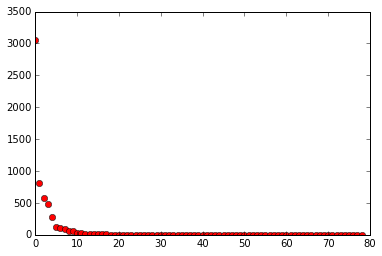

In [116]:
plt.plot(s,'ro')

Seems there about 10 important modes.

/home/val/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


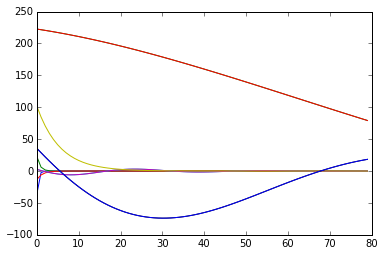

In [105]:
plt.plot(Psi.T)

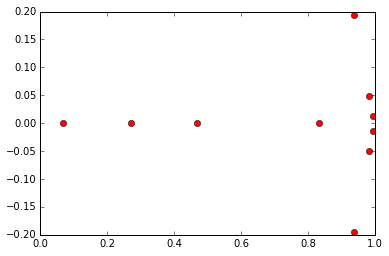

In [106]:
plt.plot(np.real(mu),np.imag(mu),'ro')

In [108]:
mu

array([ 0.06885380+0.j        ,  0.27014864+0.j        ,
        0.46853475+0.j        ,  0.93640727+0.19436573j,
        0.93640727-0.19436573j,  0.83402628+0.j        ,
        0.98196971+0.04958546j,  0.98196971-0.04958546j,
        0.99392165+0.01355482j,  0.99392165-0.01355482j])

/home/val/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


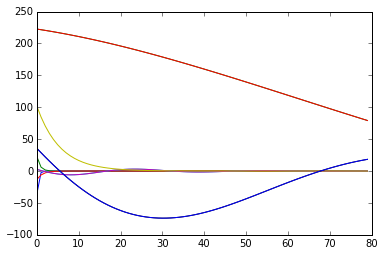

In [109]:
plt.plot()
plt.plot(Psi.T)

In [110]:
m = 10

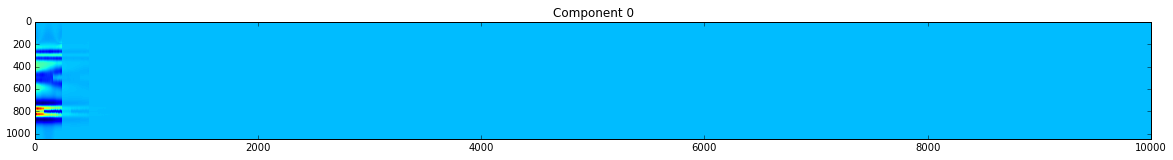

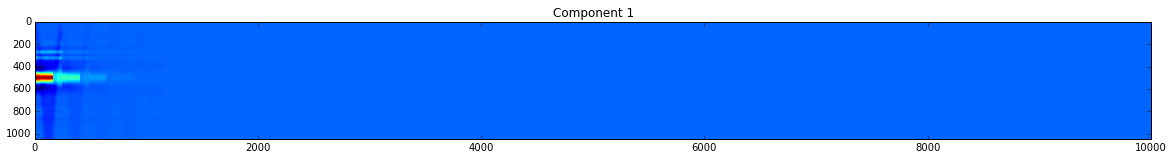

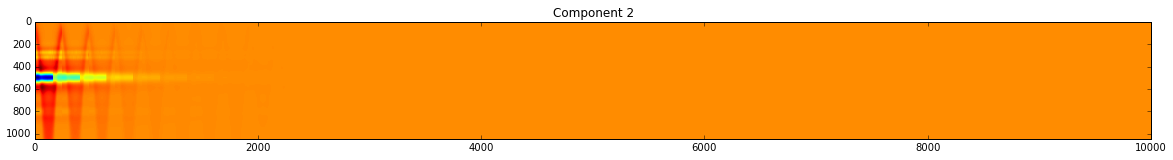

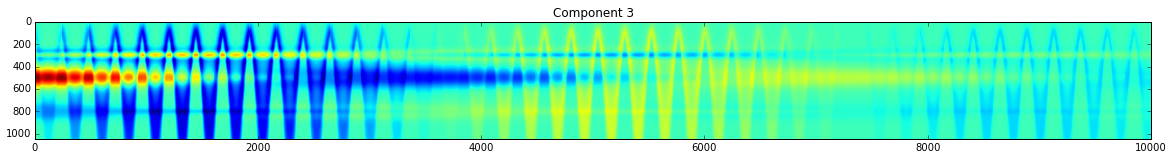

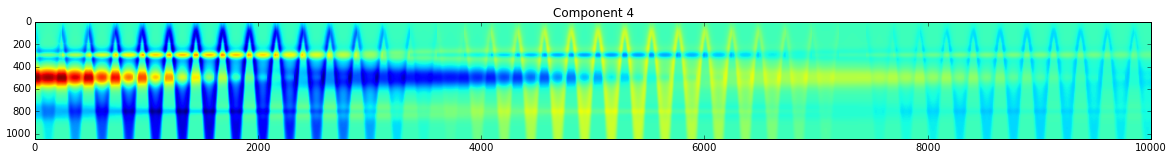

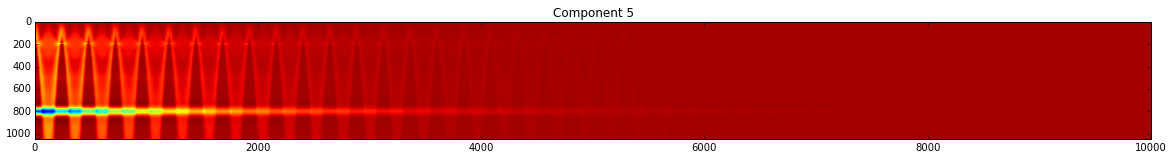

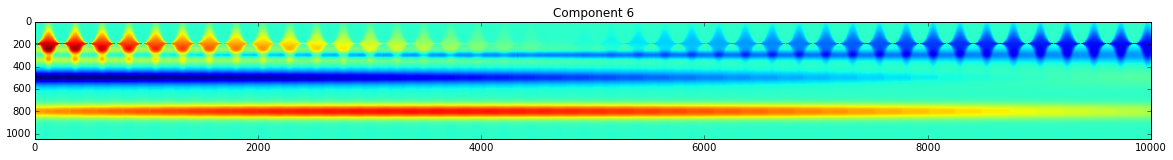

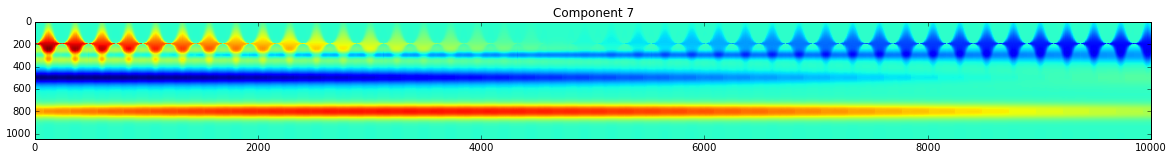

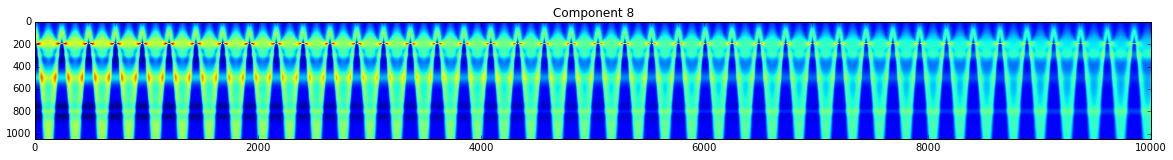

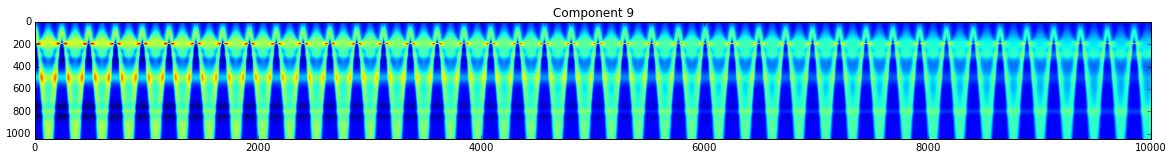

In [114]:
# displaying first individual projections on first 10 modes 
for m in range(10):
    plt.figure(figsize = (20,10))
    modeProj = np.dot(np.reshape(Phi[:,m],(d*p,1)),np.reshape(Psi[m,:],(1,T)))
    plt.imshow(np.real(modeProj).reshape((d,p*T),order = 'F')[:,:10000])
    plt.title('Component '+str(m))

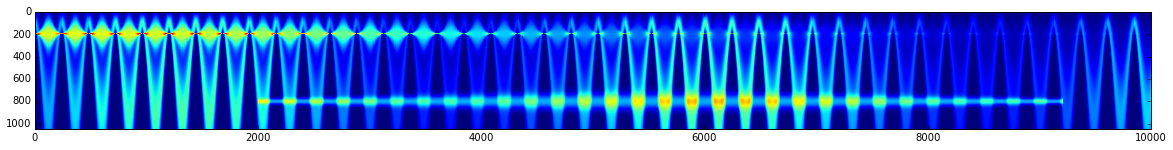

In [115]:
plt.figure(figsize = (20,10))
plt.imshow(data[:,:10000])